In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [3]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [4]:
def yunrip_data_prep():
    basedir = './국토교통부_실거래가_공개시스템/연립다세대/매매/'
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])
        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
    
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['전용면적단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
    
    concat_df['년'] = concat_df['계약날짜'].dt.year
    
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
    
    concat_df = concat_df[concat_df['년'] >= 2015]
    
    return concat_df[['지번주소'] + [col for col in concat_df.columns if col not in cols_to_drop]]

In [5]:
yunrip_df = yunrip_data_prep().dropna().reset_index(drop=True)
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 10.52it/s]


(326447, 11)


,지번주소,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,건물연식,계약날짜,전용면적단가(만원/㎡),년
0,서울특별시 강남구 개포동 1216-4,(1216-4),33.77,21.67,24800,4,2012.0,3.0,2015-03-26,734.379627,2015
1,서울특별시 강남구 개포동 1216-4,(1216-4),35.87,23.02,27200,4,2012.0,3.0,2015-06-23,758.293839,2015
2,서울특별시 강남구 개포동 1216-4,(1216-4),29.12,18.68,22200,4,2012.0,3.0,2015-07-20,762.362637,2015
3,서울특별시 강남구 개포동 1216-4,(1216-4),29.97,19.23,22500,3,2012.0,3.0,2015-08-06,750.750751,2015
4,서울특별시 강남구 개포동 170-18,(170-18),26.60,21.53,21000,1,1988.0,27.0,2015-08-21,789.473684,2015


In [6]:
def land_shape2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '사다리' in x:
            return '사다리형'
        elif '장방' in x:
            return '장방형'
        elif '정방' in x:
            return '정방형'
        elif '부정' in x:
            return '부정형'
        elif '않음' in x:
            return '지정되지않음'
        elif '자루' in x:
            return '자루형'
        elif '삼각' in x:
            return '삼각형'
        else:
            return '기타'

In [7]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
land_specs_df['지형형상2'] = land_specs_df['지형형상'].apply(land_shape2)
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 12)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가,지형형상2
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0,부정형
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0,부정형
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0,부정형
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0,부정형
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0,부정형


In [8]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,부정형
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지,부정형
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지,부정형


In [9]:
yunrip_merge_df = yunrip_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [10]:
target = '장안동'
target_purpose = '준주거'
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [11]:
target_df = yunrip_merge_df[
    (yunrip_merge_df['지번주소'].str.contains(target))
    &(yunrip_merge_df['계약날짜'] <= date_today)
    &(yunrip_merge_df['계약날짜'] >= (date_today - pd.DateOffset(years=3)))
    &(yunrip_merge_df['건물연식'] <= 3)
    &(yunrip_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(31, 20)


,지번주소,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,건물연식,계약날짜,전용면적단가(만원/㎡),년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
188449,서울특별시 동대문구 장안동 417-2,샤론인텔리안(417-2),38.68,6.13,27750,8,2016.0,2.0,2018-09-08,717.425026,2018,대,220.7,준주거지역,지정되지않음,주상용,평지,사다리형,세로한면(가),사다리형
188450,서울특별시 동대문구 장안동 417-2,샤론인텔리안(417-2),38.68,6.13,28000,7,2016.0,2.0,2018-11-06,723.888314,2018,대,220.7,준주거지역,지정되지않음,주상용,평지,사다리형,세로한면(가),사다리형
188451,서울특별시 동대문구 장안동 417-2,샤론인텔리안(417-2),38.56,6.11,29000,7,2016.0,3.0,2019-08-14,752.074689,2019,대,220.7,준주거지역,지정되지않음,주상용,평지,사다리형,세로한면(가),사다리형
278910,서울특별시 동대문구 장안동 307-2,더 하이드 파크,53.55,13.58,38000,7,2018.0,3.0,2021-03-05,709.617180,2021,대,424.3,준주거지역,지정되지않음,상업기타,평지,사다리형,소로한면,사다리형
299945,서울특별시 동대문구 장안동 466-4,성우스타팰리스,27.25,7.83,26200,9,2019.0,0.0,2019-08-27,961.467890,2019,대,648.1,준주거지역,지정되지않음,상업기타,평지,정방형,소로한면,정방형


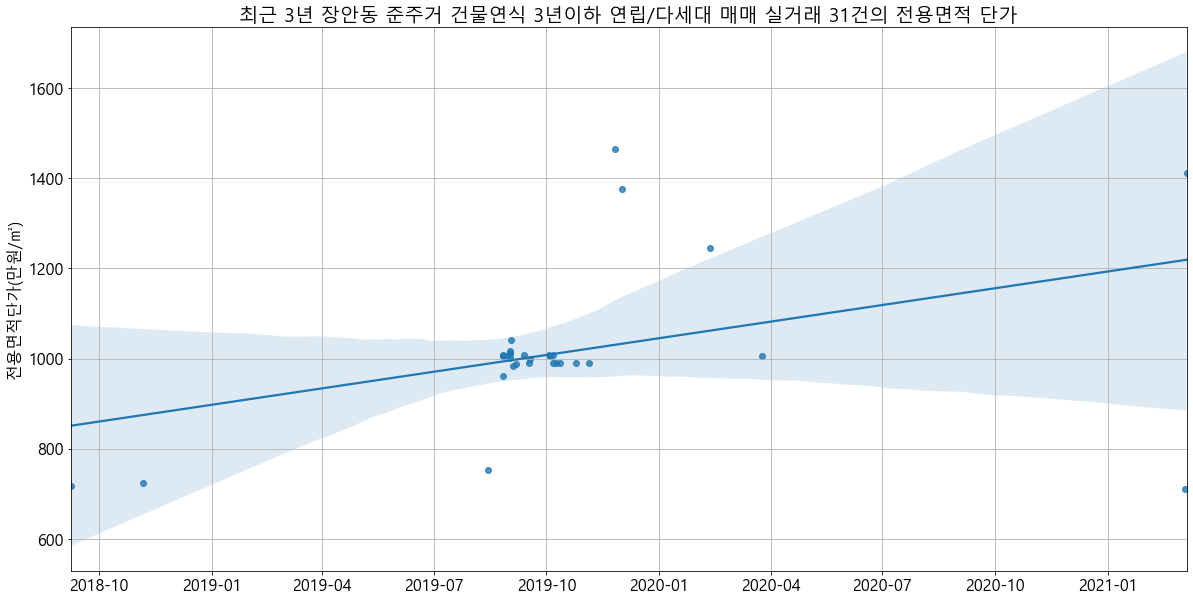

In [12]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 3년 {} {} 건물연식 3년이하 연립/다세대 매매 실거래 {}건의 전용면적 단가'.format(target, target_purpose, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['전용면적단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_연립다세대/산포도.png'.format(target))

In [13]:
target_excel = target_df.sort_values(['전용면적단가(만원/㎡)'], ascending=False).reset_index(drop=True)
target_excel['지번주소'] = target_excel['지번주소'].apply(lambda x: x.split(' ')[3])
target_excel.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_연립다세대/실거래가.xlsx'.format(target, target_purpose))